# Prediction of Breast Cancer using SVM with 99% accuracy

Using the Breast Cancer Wisconsin (Diagnostic) Database, we can create a classifier that can help diagnose patients and predict the likelihood of a breast cancer. A few machine learning techniques will be explored. In this exercise, Support Vector Machine is being implemented with 99% accuracy.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Exploratory analysis

Load the dataset and do some quick exploratory analysis.

In [42]:
data = pd.read_csv("C:/Users/divanand/Desktop/breast.csv")
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se
0,ID number,The diagnosis of breast tissues (M = malignant...,mean of distances from center to points on the...,standard deviation of gray-scale values,mean size of the core tumor,NaN,mean of local variation in radius lengths,mean of perimeter^2 / area - 1.0,mean of severity of concave portions of the co...,mean for number of concave portions of the con...,NaN,"mean for ""coastline approximation"" - 1",standard error for the mean of distances from ...,standard error for standard deviation of gray-...,NaN,NaN,standard error for local variation in radius l...,standard error for perimeter^2 / area - 1.0,standard error for severity of concave portion...,standard error for number of concave portions ...
1,1,842302,M,17.99,10.38,122.80,1001,0.1184,0.2776,0.3001,0.14710,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373
2,2,842517,M,20.57,17.77,132.90,1326,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186
3,3,84300903,M,19.69,21.25,130.00,1203,0.1096,0.1599,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832
4,4,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.00911,0.07458,0.05661


In [43]:
print(data.shape)

(570, 20)


In [63]:
data.describe()

,area_mean,symmetry_mean,perimeter_se,area_se
count,568.000000,568.000000,568.000000,568.000000
mean,92.046585,0.049005,1.216482,2.866619
std,24.249819,0.038783,0.552063,2.023593
min,43.790000,0.000000,0.360200,0.757000
25%,75.200000,0.020347,0.833150,1.605000
50%,86.290000,0.033600,1.108000,2.285500
75%,104.150000,0.074010,1.474250,3.360000
max,188.500000,0.201200,4.885000,21.980000


# Data visualisation and pre-processing

irst thing to do is to enumerate the diagnosis column such that M = 1, B = 0. Then, I set the ID column to be the index of the dataframe. Afterall, the ID column will not be used for machine learning

In [44]:
data['diagnosis'] = data['diagnosis'].apply(lambda x: '1' if x == 'M' else '0')
data = data.set_index('id')

In [45]:
print(data.groupby('diagnosis').size())

diagnosis
0    570
dtype: int64


Next, we visualise the data using density plots to get a sense of the data distribution. From the outputs below, you can see the data shows a general gaussian distribution.

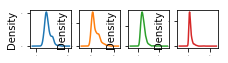

In [46]:
data.plot(kind='density', subplots=True, layout=(5,7), sharex=False, legend=False, fontsize=1)
plt.show()

It is good to check the correlations between the attributes. From the output graph below, The red around the diagonal suggests that attributes are correlated with each other. The yellow and green patches suggest some moderate correlation and the blue boxes show negative correlations.

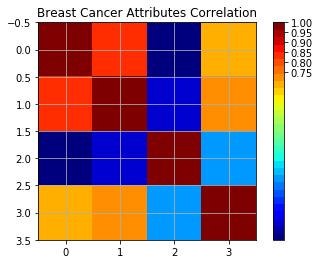

In [64]:
from matplotlib import cm as cm

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(data.corr(), interpolation="none", cmap=cmap)
ax1.grid(True)
plt.title('Breast Cancer Attributes Correlation')
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
plt.show()

In [65]:
Y = data['diagnosis'].values
X = data.drop('diagnosis', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)

# Baseline algorithm checking

rom the dataset, we will analysis and build a model to predict if a given set of symptoms lead to breast cancer. This is a binary classification problem, and a few algorithms are appropriate for use. Since we do not know which one will perform the best at the point, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform. We will use 10 fold cross validation for each testing.

The following non-linear algorithms will be used, namely: Classification and Regression Trees (CART), Linear Support Vector Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [66]:
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM', SVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

In [67]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ValueError: could not convert string to float: 'B'

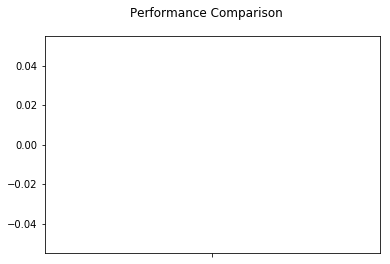

In [68]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the initial run, it looks like GaussianNB, KNN and CART performed the best given the dataset (all above 92% mean accuracy). Support Vector Machine has a surprisingly bad performance here. However, if we standardise the input dataset, it's performance should improve.

# Evaluation of algorithm on Standardised Data

The performance of the few machine learning algorithm could be improved if a standardised dataset is being used. The improvement is likely for all the models. I will use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [74]:
import warnings

# Standardize the dataset
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC( ))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsClassifier())])))
results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ValueError: could not convert string to float: 'B'

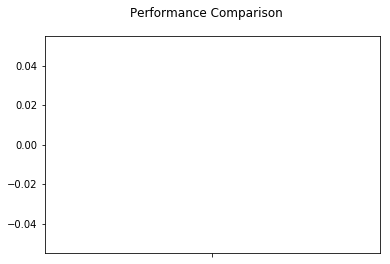

In [70]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Notice the drastic improvement of SVM after using scaled data.

Next, we'll fine tune the performance of SVM by tuning the algorithm

# Algorithm Tuning - Tuning SVM

We will focus on SVM for the algorithm tuning. We can tune two key parameter of the SVM algorithm - the value of C and the type of kernel. The default C for SVM is 1.0 and the kernel is Radial Basis Function (RBF). We will use the grid search method using 10-fold cross-validation with a standardized copy of the sample training dataset. We will try over a combination of C values and the following kernel types 'linear', 'poly', 'rbf' and 'sigmoid

In [71]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ValueError: could not convert string to float: 'B'

e can see the most accurate configuration was SVM with an RBF kernel and C=1.5, with the accuracy of 96.92%

# Application of SVC on dataset

Let's fit the SVM to the dataset and see how it performs given the test data.

In [72]:
# prepare the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = SVC(C=2.0, kernel='rbf')
start = time.time()
model.fit(X_train_scaled, Y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

ValueError: could not convert string to float: 'B'

In [75]:
# estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_test_scaled = scaler.transform(X_test)
    predictions = model.predict(X_test_scaled)

NameError: name 'scaler' is not defined

In [76]:
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

NameError: name 'predictions' is not defined

In [77]:
print(confusion_matrix(Y_test, predictions))

NameError: name 'predictions' is not defined